In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from sklearn.cross_validation import StratifiedKFold
import matplotlib.pyplot as plt
%run /home/ryan/ml/dm/lda_functions.py
#from sklearn.lda import LDA #remove this later

In [5]:
dat = pd.read_csv('sun.csv',index_col=0)
y = np.array(dat['label'])
X = np.array(dat.ix[:,1:])
names = dat.columns
i_nan = np.where(X!=X) # correct a single nan value
X[i_nan] = np.nanmean(X[:,i_nan[1]])

In [6]:
folds = pd.read_csv('/home/ryan/ml/dm/folds.csv')
folds = np.array(folds)
folds
n_cv = 5
i_tr = folds.any(axis=1)
folds = [(~row,row) for row in folds[i_tr].T[:n_cv]]

In [122]:
def penalized_lda_cv(X,y,regs=None, K=None, n_folds=6, folds=None):
    if folds is None:
        folds = StratifiedKFold(y,n_folds)
    if y.dtype != int:
        raise ValueError('y must be an array of integers')
    if regs is None:
        regs = np.logspace(.1,10,5)
        
    # if only one K value needs to be used
    if K is not None or len(set(y))==2:
        if len(set(y))==2:
            K = 1
        err = np.zeros((len(folds),len(regs)))
        nonzero_betas = np.zeros((len(folds),len(regs)))
        
        for (i_fold, (tr,val)) in enumerate(folds):
            print('fold',i_fold)
            Xtr = X[tr,:]
            ytr = y[tr]
            Xval = X[val,:]
            yval = y[val]
            
            # scale data using mean and within-class standard deviation from training set
            wcsds = within_class_sds(Xtr,ytr)
            if 0 in wcsds:
                raise ValueError('Some features have 0 within-class standard deviation')
            else:
                means = Xtr.mean(axis=0)
                Xtr = (Xtr - means) / wcsds
                Xval = (Xval - means) / wcsds
            
            for (i_reg, reg) in enumerate(regs):
                print('lambda',reg)
                discrim = penalized_lda_fit(Xtr,ytr,reg,K=K,standardized=True)[1]
                y_pred = lda_predict(Xtr,ytr,Xval,discrim,K)
                print('predicted y:')
                print(y_pred)
                err[i_fold,i_reg] = (y_pred!=yval).sum()
                nonzero_betas[i_fold,i_reg] = (discrim!=0).any(axis=1).sum(axis=0)
        err_mean = err.mean(axis=0)
        nonzero_mean = nonzero_betas.mean(axis=0)
        reg_best = regs[err_mean.argmin()]
        return(err_mean, nonzero_mean, reg_best, K,nonzero_betas,err)
    
    # if it is necessary to cross-validate over K values
    else:
        Ks = [i for i in range(1,len(set(y)))]
        err = np.zeros((len(folds),len(regs),len(Ks)))
        nonzero_betas = np.zeros((len(folds),len(regs),len(Ks)))
        for (i_fold, (tr,val)) in enumerate(folds)
            print('fold',i_fold)
            Xtr = X[tr,:]
            ytr = y[tr]
            Xval = X[val,:]
            yval = y[val]
            
            # scale data using mean and within-class standard deviation from training set
            wcsds = within_class_sds(Xtr,ytr)
            if 0 in wcsds:
                raise ValueError('Some features have 0 within-class standard deviation')
            else:
                means = Xtr.mean(axis=0)
                Xtr = (Xtr - means) / wcsds
                Xval = (Xval - means) / wcsds
            
            for (i_reg, reg) in enumerate(regs):
                print('lambda',reg)
                discrim = penalized_lda_fit(Xtr,ytr,reg,K=max(Ks),
                                                standardized=True)[1]
                for i_k,k in enumerate(Ks):
                    ypred = lda_predict(Xtr,ytr,Xval,discrim,k)
                    print('predicted y:')
                    print(ypred)
                    err[i_fold,i_reg,i_k] = (ypred!=yval).sum()
                    nonzero_betas[i_fold,i_reg,i_k] = discrim[:,:k].any(axis=1).sum(axis=0)
    
        err_mean = err.mean(axis=0)
        nonzero_mean = nonzero_betas.mean(axis=0)
        i_best_params = np.unravel_index(err_mean.argmin(),err_mean.shape)
        reg_best = regs[i_best_params[0]]
        K_best = Ks[i_best_params[1]]
        return(err_mean, nonzero_mean, reg_best, K_best,nonzero_betas,err)

In [11]:
class PenalizedLDACV:
    def __init__(self, regs = None, Ks = None, max_iter = 20):
        self.regs = regs
        self.Ks = Ks
        self.max_iter = max_iter
        self.K_selected_ = None
        self.reg_selected_ = None
    def fit(self,X,y,standardized=False,n_folds=5,folds=None):
        if folds is None:
            folds = StratifiedKFold(y,n_folds)
        if y.dtype != int:
            raise ValueError('y must be an array of integers')
        if self.regs is None:
            self.regs = np.logspace(.1,10,5)
        if self.Ks is not None and (np.array(self.Ks) >= len(set(y))).any():
            raise ValueError('K must be less than the number of unique classes')
        
        # if only one K value needs to be used
        if len(set(y))==2:
            self.Ks = 1
            self.K_selected_ = 1
        if self.Ks is not None:
            err = np.zeros((len(folds),len(self.regs)))
            self.nonzero_betas_ = np.zeros((len(folds),len(self.regs)))

            for (i_fold, (tr,val)) in enumerate(folds):
                print('fold',i_fold)
                Xtr = X[tr,:]
                ytr = y[tr]
                Xval = X[val,:]
                yval = y[val]

                # compute mean and within-class SD from training fold, then scale data
                self.wcsds_ = within_class_sds(Xtr,ytr)
                
                if 0 in self.wcsds_:
                    raise ValueError('Some features have 0 within-class standard deviation')
                else:
                    self.means_ = Xtr.mean(axis=0)
                    Xtr = (Xtr - self.means_) / self.wcsds_
                    Xval = (Xval - self.means_) / self.wcsds_
                    
                # the clf classifier is trained with each regularisation parameter
                clf = PenalizedLDA(K = self.K_selected_)
                for (i_reg, reg) in enumerate(self.regs):
                    print('lambda',reg)
                    clf.reg = reg
                    clf.fit(Xtr,ytr,standardized=True)
                    self.nonzero_betas_[i_fold,i_reg] = (clf.discrim_[:,:self.K_selected_]
                                                        ).any(axis=1).sum(axis=0)
                    err[i_fold,i_reg] = clf.error(Xval,yval,standardized=True)
                    
            self.err_mean_ = err.mean(axis=0)
            self.nonzero_mean_ = self.nonzero_betas_.mean(axis=0)
            self.reg_selected_ = self.regs[self.err_mean_.argmin()]
            
        # if it is necessary to cross-validate over K values
        else:
            self.Ks = [i for i in range(1,len(set(y)))]
            err = np.zeros((len(folds),len(self.regs),len(self.Ks)))
            self.nonzero_betas_ = np.zeros((len(folds),len(self.regs),len(self.Ks)))
            for (i_fold, (tr,val)) in enumerate(folds):
                print('fold',i_fold)
                Xtr = X[tr,:]
                ytr = y[tr]
                Xval = X[val,:]
                yval = y[val]

                # scale X using mean and within-class standard deviation from training set
                self.wcsds_ = within_class_sds(Xtr,ytr)
                if 0 in self.wcsds_:
                    raise ValueError('Some features have 0 within-class standard deviation')
                else:
                    self.means_ = Xtr.mean(axis=0)
                    Xtr = (Xtr - self.means_) / self.wcsds_
                    Xval = (Xval - self.means_) / self.wcsds_
                
                # the clf classifier is trained with each combination of hyperparameters
                clf = PenalizedLDA(K=max(self.Ks))
                for (i_reg, reg) in enumerate(self.regs):
                    print('lambda',reg)
                    clf.reg = reg
                    clf.fit(Xtr,ytr,standardized=True)
                    for i_k,k in enumerate(self.Ks):
                        err[i_fold,i_reg,i_k] = clf.error(Xval,yval,k=k,standardized=True)
                        self.nonzero_betas_[i_fold,i_reg,i_k] = (clf.discrim_[:,:k]
                                                                ).any(axis=1).sum(axis=0)

            self.err_mean_ = err.mean(axis=0)
            self.nonzero_mean_ = self.nonzero_betas_.mean(axis=0)
            i_best_params = np.unravel_index(self.err_mean_.argmin(),self.err_mean_.shape)
            self.reg_selected_ = self.regs[i_best_params[0]]
            self.K_selected_ = self.Ks[i_best_params[1]]
            
        # refit model with selected parameters
        selected_model = PenalizedLDA(reg=self.reg_selected_,K=self.K_selected_)
        selected_model.fit(X,y)
        self.discrim_selected_ = selected_model.discrim_
        self.X_proj_ = selected_model.Xtr_proj_
        self.y_ = y
        return(self)

    def predict(self,Xte,standardized=False,k=None):
        if not standardized:
            #set mean to zero and within-class variance to one
            Xte = (Xte-self.means_)/self.wcsds_

        #project to dimensionality k using discriminant
        Xte_projected = Xte.dot(self.discrim_selected_[:,:k])

        #predict class as nearest centroid in projected space
        y_predicted = classify(self.X_proj_[:,:k],self.y_,Xte_projected)

        return(y_predicted)
    def error(self,Xte,yte,k=None, standardized=False):
        if yte.dtype != int:
            raise ValueError('yte must be an array of integers')
        err = (self.predict(Xte,k=k,standardized=standardized)!=yte).sum()
        return(err)
    def __repr__(self):
        return(('Penalized LDA(regs={regs}, Ks={Ks}, max_iter={max_iter}, self.K_selected_='+
               '{K_selected_}, self.reg_selected_={reg_selected_})').format(
                regs=self.regs, Ks=self.Ks, max_iter=self.max_iter, 
                K_selected_=self.K_selected_, reg_selected_=self.reg_selected_))

In [12]:
%run /home/ryan/ml/dm/lda_functions.py
ldacv = PenalizedLDACV(regs=[.006,.007,.008],Ks=2)
ldacv.fit(X[i_tr],factor_to_integer(y)[i_tr],folds=folds)
ldacv.predict(X[~i_tr])
ldacv

fold 0
lambda 0.006
lambda 0.007
lambda 0.008
fold 1
lambda 0.006
lambda 0.007
lambda 0.008
fold 2
lambda 0.006
lambda 0.007
lambda 0.008
fold 3
lambda 0.006
lambda 0.007
lambda 0.008
fold 4
lambda 0.006
lambda 0.007
lambda 0.008


Penalized LDA(regs=[0.006, 0.007, 0.008], Ks=2, max_iter=20, self.K_selected_=None, self.reg_selected_=0.007)

In [13]:
print(ldacv.err_mean_,'\n', ldacv.nonzero_mean_)

[ 6.4  6.2  6.2] 
 [ 41382.8  34257.   23620.2]


In [18]:
%run /home/ryan/ml/dm/lda_functions.py
ldacv = PenalizedLDACV(regs=[.006,.007,.008])
ldacv.fit(X[i_tr],factor_to_integer(y)[i_tr],folds=folds)
ldacv.predict(X[~i_tr])
ldacv

fold 0
lambda 0.006
lambda 0.007
lambda 0.008
fold 1
lambda 0.006
lambda 0.007
lambda 0.008
fold 2
lambda 0.006
lambda 0.007
lambda 0.008
fold 3
lambda 0.006
lambda 0.007
lambda 0.008
fold 4
lambda 0.006
lambda 0.007
lambda 0.008


Penalized LDA(regs=[0.006, 0.007, 0.008], Ks=[1, 2, 3], max_iter=20, self.K_selected_=3, self.reg_selected_=0.007)

In [17]:
print(ldacv.err_mean_,'\n', ldacv.nonzero_mean_)

[[ 8.4  7.2  6.4]
 [ 8.2  7.4  6.2]
 [ 8.4  7.4  6.2]] 
 [[ 20170.8  32141.   41382.8]
 [ 15252.   25280.6  34257. ]
 [ 10054.2  17041.8  23620.2]]


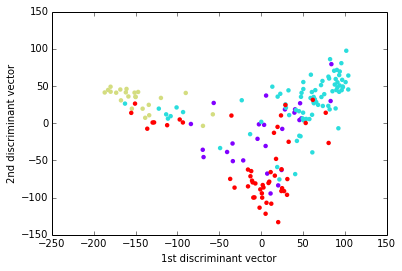

In [12]:
lda.fit(X,factor_to_integer(y))
plt.scatter(lda.Xtr_proj_[:,0],lda.Xtr_proj_[:,1],c=factor_to_integer(y),
            cmap='rainbow',linewidths=0)
plt.xlabel('1st discriminant vector')
plt.ylabel('2nd discriminant vector')
plt.show()